# 06 - CNN models - VGG19

In this notebook, we are going to do CNN model (with transfer Learning from VGG19).

(Also gonna work with a sample of our dataset to be able to evaluate faster the results.
Our sample is gonna be equalized/normalized by the classes, an equal amount for each class)

### Steps: 
 - Importing/accessing the data
 - Separating the Train and Test Data
 - Fitting the model(vgg19 -> working with 3 channels)
 - Evaluate the model
    - Accuracy, Precision, Recall, f1  .....  Confusion Matrix 
 - Using the model to predict the specific images

## Importing/accessing the data

First, importing the libs and treating the data:

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

dataset_directory = '../datasets/dataset_normal/'

# Load and preprocess images
def load_images(directory):
    images = []
    labels = []
    for label, folder in enumerate(os.listdir(directory)):
        for filename in os.listdir(os.path.join(directory, folder)):
            img = cv2.imread(os.path.join(directory, folder, filename))
            img = cv2.resize(img, (100, 100))  # Resize image
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
            images.append(img.flatten())  # Flatten image
            labels.append(label)
    return np.array(images), np.array(labels)

# Feature extraction
images, labels = load_images(dataset_directory)

# Feature scaling (optional but recommended)
images = images / 255.0  # Scale pixel values to range [0, 1]


In [2]:
# Sanity Check
images.shape
# labels

(17092, 30000)

## Separeting the Train and Test Data

Spliting data into training and testing sets

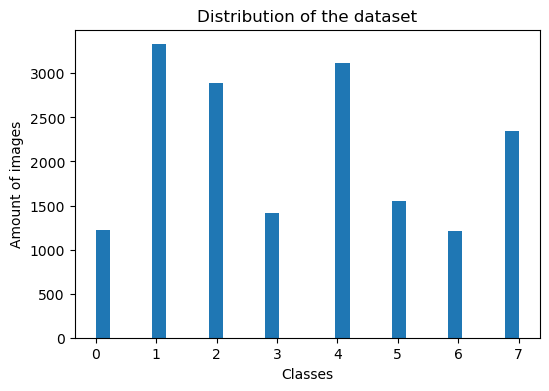

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(labels, bins=30)
plt.title('Distribution of the dataset')
plt.xlabel('Classes')
plt.ylabel('Amount of images')
plt.show()

In [4]:
# Balancing da dataset
from sklearn.utils import resample

# Calculate the size of the smallest class
min_class_size = min(np.bincount(labels))

# Undersampling majority classes to match the size of the minority class
X_balanced = []
y_balanced = []
for i in range(8):  # Assuming we have 8 classes
    X_class_i = images[labels == i]
    y_class_i = labels[labels == i]
    X_class_i_resampled, y_class_i_resampled = resample(X_class_i, y_class_i, n_samples=min_class_size, random_state=42)
    X_balanced.append(X_class_i_resampled)
    y_balanced.append(y_class_i_resampled)

X = np.concatenate(X_balanced)
y = np.concatenate(y_balanced)

print(X.shape)
print(y.shape)

# #-------------------------
# #-------------------------
# # Oversampling minority classes to match the size of the majority class
# # You can use techniques like SMOTE for better synthetic sampling
# # Here, I'm just duplicating existing samples
# X_train_balanced_oversampled = []
# y_train_balanced_oversampled = []
# for i in range(8):  # Assuming you have 8 classes
#     X_class_i = X_train[y_train == i]
#     y_class_i = y_train[y_train == i]
#     X_class_i_oversampled, y_class_i_oversampled = resample(X_class_i, y_class_i, n_samples=len(X_train_balanced), random_state=42)
#     X_train_balanced_oversampled.append(X_class_i_oversampled)
#     y_train_balanced_oversampled.append(y_class_i_oversampled)

# X_train_balanced_oversampled = np.concatenate(X_train_balanced_oversampled)
# y_train_balanced_oversampled = np.concatenate(y_train_balanced_oversampled)


(9712, 30000)
(9712,)


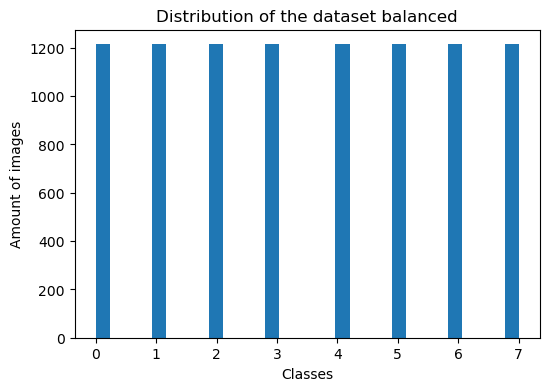

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(y, bins=30)
plt.title('Distribution of the dataset balanced')
plt.xlabel('Classes')
plt.ylabel('Amount of images')
plt.show()

In [6]:
# Spliting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, stratify=y, random_state=42)


In [7]:
# Print info on how the data has been split
print(f'The TRAIN set has {len(X_train)} data points.')
print(f'The TEST set has {len(X_test)} data points.')

The TRAIN set has 7769 data points.
The TEST set has 1943 data points.


In [8]:
# print(X_train.shape)
# print(y_train.shape)
# print(X_test.shape)
# print(y_test.shape)

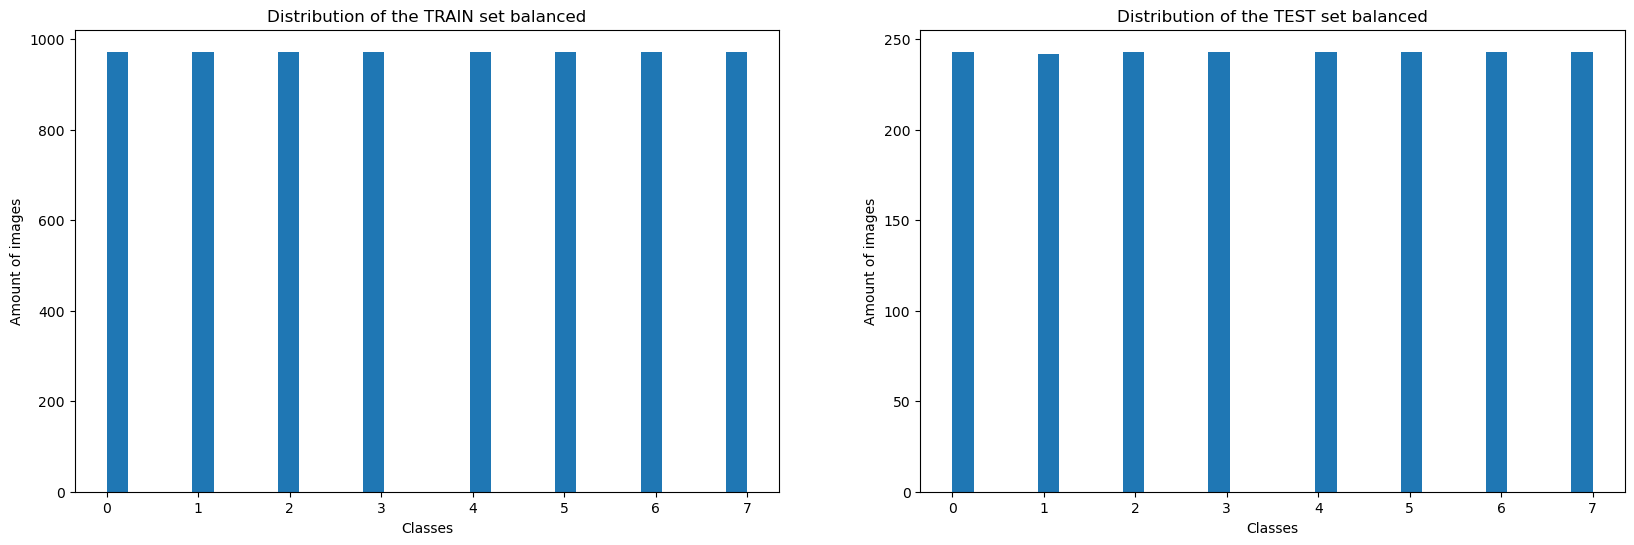

In [9]:
# Plotting the y_ values 
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.hist(y_train, bins=30)
plt.title('Distribution of the TRAIN set balanced')
plt.xlabel('Classes')
plt.ylabel('Amount of images')

plt.subplot(1, 2, 2)
plt.hist(y_test, bins=30)
plt.title('Distribution of the TEST set balanced')
plt.xlabel('Classes')
plt.ylabel('Amount of images')

plt.show()

## Training the model (train the logistic regression)

Training/fiting the models

In [10]:
# Seeing the hardware that you have at your dispose

import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### VGG19

In [11]:
#import the base model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

from tensorflow.keras.applications import VGG19

vgg_model = VGG19(
    include_top=False,
    input_shape=(100,100,3),
    pooling=None,
)

vgg_model.summary()

2024-04-14 19:31:54.602212: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-14 19:31:54.602242: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-14 19:31:54.602246: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-14 19:31:54.602315: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-14 19:31:54.602496: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [12]:
# Freeze all the layers in the base model
for layer in vgg_model.layers:
    layer.trainable = False

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.python.keras import layers
from tensorflow.python.keras.models import Sequential
from tensorflow import keras

# Adding more layers
x = vgg_model.output
x = Flatten()(x) 
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
output = Dense(8, activation='softmax')(x)


In [14]:
# Binding both 'models'
model = Model(inputs=vgg_model.input, 
              outputs=output)

# Defining the optimizer, loss and metrics
# set_random_seed(121)
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [15]:
# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=3,
                           mode='min', 
                           verbose=1)


In [16]:
from tensorflow.keras.utils import to_categorical

# Reshape flattened input data back to images
X_train_images = X_train.reshape(-1, 100, 100, 3)
X_test_images = X_test.reshape(-1, 100, 100, 3)

# y_train_balanced contains target labels
# Converting target labels to one-hot encoded format
y_train_encoded = to_categorical(y_train, num_classes=8)
y_test_encoded = to_categorical(y_test, num_classes=8)

In [17]:
# Training the model
history = model.fit(
    X_train_images,
    y_train_encoded,
          epochs=15,
    validation_data=(X_test_images, y_test_encoded),
          # callbacks=[early_stop]
         )

Epoch 1/15


2024-04-14 19:25:42.385801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


243/243 [==============================] - ETA: 0s - loss: 2.0499 - accuracy: 0.2924

2024-04-14 19:25:56.134270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


243/243 [==============================] - 17s 70ms/step - loss: 2.0499 - accuracy: 0.2924 - val_loss: 1.5937 - val_accuracy: 0.3634
Epoch 2/15
243/243 [==============================] - 17s 68ms/step - loss: 1.3503 - accuracy: 0.4850 - val_loss: 1.2445 - val_accuracy: 0.5172
Epoch 3/15
243/243 [==============================] - 16s 67ms/step - loss: 1.0616 - accuracy: 0.6108 - val_loss: 1.0377 - val_accuracy: 0.6238
Epoch 4/15
243/243 [==============================] - 16s 68ms/step - loss: 0.9187 - accuracy: 0.6660 - val_loss: 1.0449 - val_accuracy: 0.5970
Epoch 5/15
243/243 [==============================] - 16s 67ms/step - loss: 0.8430 - accuracy: 0.6884 - val_loss: 0.8691 - val_accuracy: 0.6891
Epoch 6/15
243/243 [==============================] - 17s 68ms/step - loss: 0.7633 - accuracy: 0.7270 - val_loss: 0.7849 - val_accuracy: 0.7180
Epoch 7/15
243/243 [==============================] - 17s 68ms/step - loss: 0.6934 - accuracy: 0.7587 - val_loss: 0.7524 - val_accuracy: 0.7427
Epo

In [18]:
# Evaluate the model's performance on the test data
# Accuracy
score = model.evaluate(X_test_images, y_test_encoded, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

61/61 [==============================] - 3s 53ms/step - loss: 0.6022 - accuracy: 0.7988
Test loss: 0.6022320985794067
Test accuracy: 0.7987648248672485


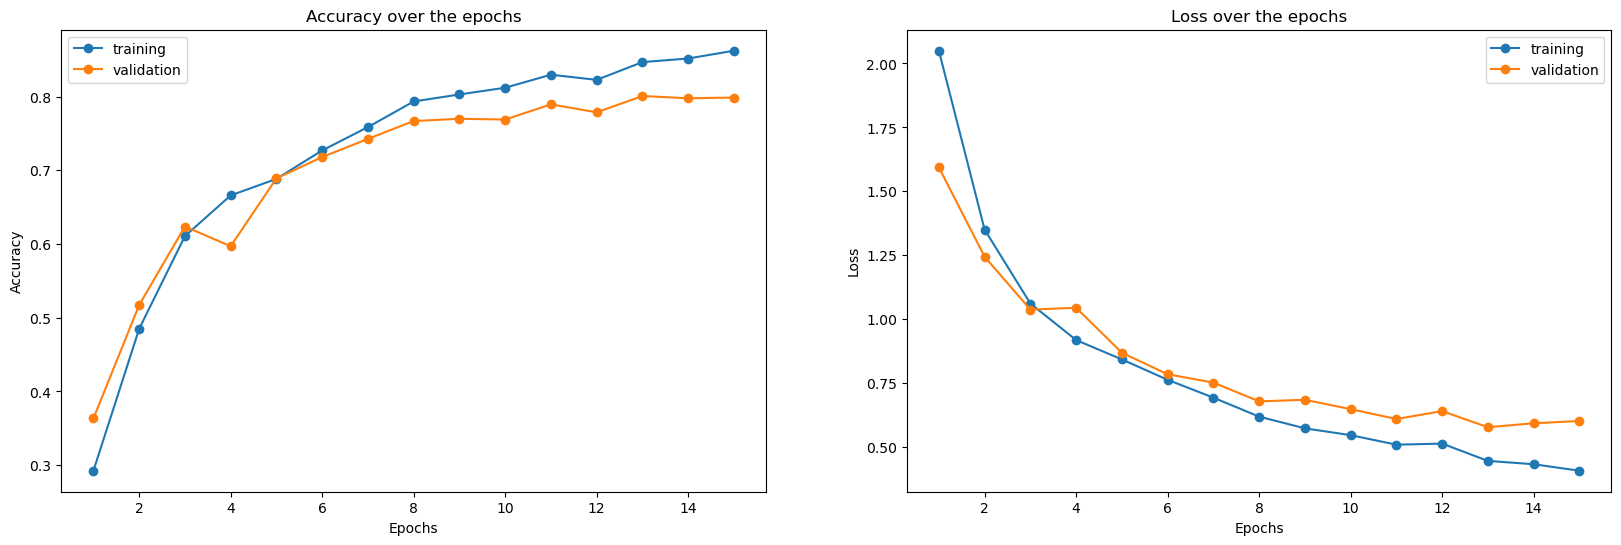

In [20]:
epochs = range(1, 16)

plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], label="training", marker="o")
plt.plot(epochs, history.history["val_accuracy"], label="validation", marker="o")
plt.title("Accuracy over the epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], label="training", marker="o")
plt.plot(epochs, history.history["val_loss"], label="validation", marker="o")
plt.title("Loss over the epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

The optimal number of epochs is 13

#### Making the model with the best number of Epochs

In [17]:
# #Training with the best epochs

# # Training the model
history = model.fit(
    X_train_images,
    y_train_encoded,
          epochs=13,
    validation_data=(X_test_images, y_test_encoded),
          # callbacks=[early_stop]
         )

Epoch 1/13


2024-04-14 19:32:06.269037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


243/243 [==============================] - ETA: 0s - loss: 1.9672 - accuracy: 0.2973

2024-04-14 19:32:20.055850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


243/243 [==============================] - 17s 70ms/step - loss: 1.9672 - accuracy: 0.2973 - val_loss: 1.6455 - val_accuracy: 0.3747
Epoch 2/13
243/243 [==============================] - 16s 68ms/step - loss: 1.4592 - accuracy: 0.4322 - val_loss: 1.3196 - val_accuracy: 0.4864
Epoch 3/13
243/243 [==============================] - 16s 67ms/step - loss: 1.2390 - accuracy: 0.5366 - val_loss: 1.1930 - val_accuracy: 0.5368
Epoch 4/13
243/243 [==============================] - 16s 67ms/step - loss: 1.1174 - accuracy: 0.6057 - val_loss: 1.2067 - val_accuracy: 0.5543
Epoch 5/13
243/243 [==============================] - 16s 67ms/step - loss: 1.0054 - accuracy: 0.6455 - val_loss: 1.0665 - val_accuracy: 0.6099
Epoch 6/13
243/243 [==============================] - 16s 67ms/step - loss: 0.9177 - accuracy: 0.6814 - val_loss: 0.9397 - val_accuracy: 0.6660
Epoch 7/13
243/243 [==============================] - 16s 67ms/step - loss: 0.8307 - accuracy: 0.7203 - val_loss: 0.8351 - val_accuracy: 0.6999
Epo

In [19]:
# Showing the Accuracy from train and test
print('Train accuracy:', history.history["accuracy"][-1])
print('Test accuracy:', history.history["val_accuracy"][-1])

Train accuracy: 0.8183807730674744
Test accuracy: 0.774575412273407


In [20]:
# # Checking the model's performance to ensure
score = model.evaluate(X_test_images, y_test_encoded, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

61/61 [==============================] - 3s 54ms/step - loss: 0.6537 - accuracy: 0.7746
Test loss: 0.6537250280380249
Test accuracy: 0.774575412273407


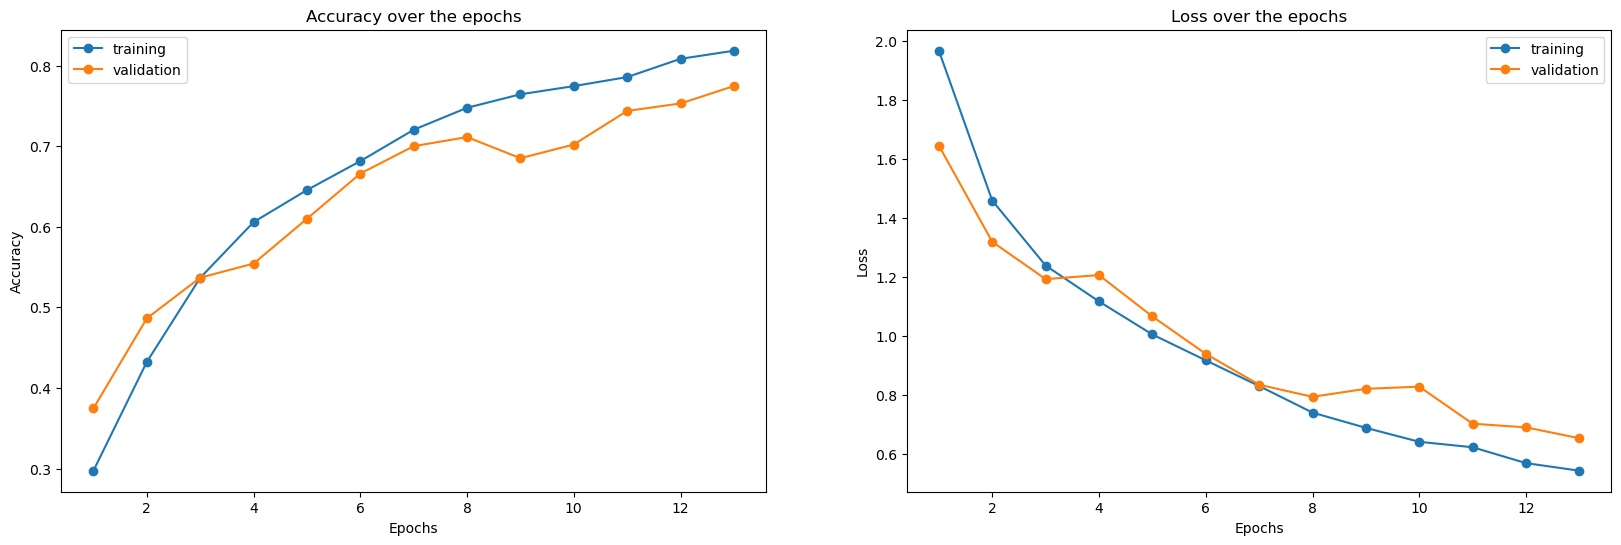

In [24]:
epochs = range(1, 14)

plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], label="training", marker="o")
plt.plot(epochs, history.history["val_accuracy"], label="validation", marker="o")
plt.title("Accuracy over the epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], label="training", marker="o")
plt.plot(epochs, history.history["val_loss"], label="validation", marker="o")
plt.title("Loss over the epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Evaluete the model

Seeing how the model peform with the train and test data:

### Accuracy, Precision, Recall, f1

Getting Accuracy, Precision, Recall and f1 from the model and seeing in each class

In [25]:
# Accuracy
score = model.evaluate(X_test_images, y_test_encoded, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

61/61 [==============================] - 3s 53ms/step - loss: 0.6537 - accuracy: 0.7746
Test loss: 0.6537250280380249
Test accuracy: 0.774575412273407


In [26]:
# Predicting
y_score = model.predict(X_test_images)

 3/61 [>.............................] - ETA: 2s

2024-04-14 19:39:05.806689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


61/61 [==============================] - 3s 55ms/step


In [27]:
# ONE-HOT ENCODE
# Convert probabilities to label encoding
y_predict = np.argmax(y_score, axis=1)

# Convert one-hot encoded labels to class labels for y_test
y_test_labels = np.argmax(y_test_encoded, axis=1)


In [28]:
# Sanity check on the encode
accuracy = accuracy_score(y_test_labels, y_predict)
print("Accuracy:", accuracy)

Accuracy: 0.7745753988677303


### Classification_report

In [30]:
from sklearn.metrics import classification_report

# Generate classification report
report_initial = classification_report(y_test_labels, y_predict)
print(report_initial)

              precision    recall  f1-score   support

           0       0.87      0.73      0.79       243
           1       0.83      0.82      0.83       242
           2       0.64      0.57      0.60       243
           3       0.59      0.74      0.66       243
           4       0.89      0.82      0.85       243
           5       0.75      0.73      0.74       243
           6       0.74      0.87      0.80       243
           7       0.96      0.91      0.93       243

    accuracy                           0.77      1943
   macro avg       0.78      0.77      0.78      1943
weighted avg       0.78      0.77      0.78      1943



### Confusion Matrix 

Plotting the confusion Matrix (as a porcentage) and observate the classification from the model

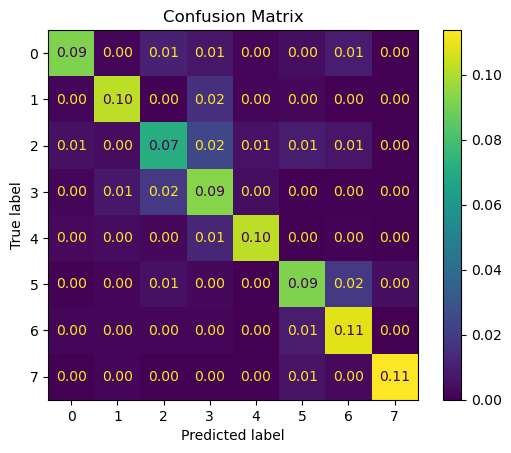

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test_labels, y_predict, normalize='all', values_format='.2f')
plt.title('Confusion Matrix')
plt.show()


In [33]:
cells = {
    0 : 'basophil',
    1 : 'eosinophil',
    2 : 'erythroblast',
    3 : 'ig',
    4 : 'lymphocyte',
    5 : 'monocyte',
    6 : 'neutrophil',
    7 : 'platelet',
}

## Using the model to predict the specifics images

In [34]:
# Load the model 

# logreg = joblib.load('../models/logistic_regression_model.pkl')
# result = logreg.score(X_test, y_test)
# print(result)

1/1 [==============================] - 0s 15ms/step
1
The cell that was detect was: eosinophil


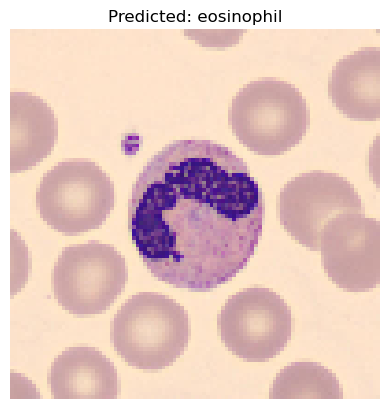

In [62]:
# filename = '../datasets/dataset_normal/basophil/BA_47.jpg'            #gets wrong
# filename = '../datasets/dataset_normal/eosinophil/EO_115441.jpg'      #gets wrong
# filename = '../datasets/dataset_normal/erythroblast/ERB_101704.jpg'   #gets wrong
# filename = '../datasets/dataset_normal/ig/IG_394276.jpg'              #gets wrong
# filename = '../datasets/dataset_normal/lymphocyte/LY_109414.jpg'      #gets wrong
# filename = '../datasets/dataset_normal/monocyte/MO_116903.jpg'        #gets wrong
filename = '../datasets/dataset_normal/neutrophil/BNE_12343.jpg'      #gets wrong
# filename = '../datasets/dataset_normal/platelet/PLATELET_101132.jpg'  #gets right

img = cv2.imread(filename)
img = cv2.resize(img, (100, 100))  # Resize image
img = img.astype('float32') / 255.0  # Normalize pixel values
image = np.expand_dims(img, axis=0)  # Add batch dimension

# Predict
result = model.predict(image)
predicted_class = np.argmax(result)

# print(result)
print(np.argmax(result))
print(f"The cell that was detect was: {cells[np.argmax(result)]}")

# Display the image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted: {cells[predicted_class]}")
plt.axis('off')
plt.show()